In [1]:
#from Adapt import AdaptVQE_Y

from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
import warnings
from qiskit_nature.circuit.library import HartreeFock,UCCSD
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator

from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import AdaptVQE
from qiskit.circuit import QuantumCircuit

from qiskit_nature.settings import QiskitNatureSettings
QiskitNatureSettings.dict_aux_operators = True

import numpy as np 
warnings.filterwarnings("ignore")

/tmp/ipykernel_21924/1295061952.py:17: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
/tmp/ipykernel_21924/1295061952.py:17: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory


In [2]:
molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["O", [0.0, 0.0, 0.0]],
        ["H", [0.758602, 0.0, 0.504284]],
        ["H", [0.758602, 0.0, -0.504284]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

#driver = PySCFDriver(atom="O 0 0 0;H 0.758602 0 0.504284;H 0.758602 0 -0.504284",basis="sto-3g")

properties = driver.run()
converter = QubitConverter(JordanWignerMapper())
PN_property = properties.get_property("ParticleNumber")
print(PN_property)

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, #how many electrons we have in our active space
    num_molecular_orbitals=2, #how many orbitals we have in our active space
)

problem = ElectronicStructureProblem(driver, [transformer])
#problem = ElectronicStructureProblem(driver)
second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print('轨道数目：{a}\n粒子数目{b}\n'.format(a=num_spin_orbitals,b=num_particles))


ParticleNumber:
	14 SOs
	5 alpha electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]
	5 beta electrons
		orbital occupation: [1. 1. 1. 1. 1. 0. 0.]
轨道数目：4
粒子数目(1, 1)



In [3]:
from qiskit.circuit import Instruction
def Instruction_topart(instruction:Instruction):
    qc = QuantumCircuit(instruction.num_qubits)
    qc.append(instruction,range(instruction.num_qubits))
    temp = qc.decompose(reps=2)
    Instruction_set=[]
    for i in range(qc.num_parameters):
        Instruction_set.append(temp[i])
    
    return Instruction_set
    

In [4]:

from Adapt import AdaptVQE_Y
from qiskit_nature.second_q.operators import FermionicOp
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit import QuantumCircuit
a = AdaptVQE_Y(es_problem=problem)
#a.operator_pool

In [10]:
a.opertor_instruction

[CircuitInstruction(operation=Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[ParameterExpression(1.0*sd[0])]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=()),
 CircuitInstruction(operation=Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[ParameterExpression(1.0*sd[1])]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=()),
 CircuitInstruction(operation=Instruction(name='PauliEvolution', num_qubits=4, num_clbits=0, params=[ParameterExpression(1.0*sd[2])]), qubits=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1), Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 3)), clbits=())]

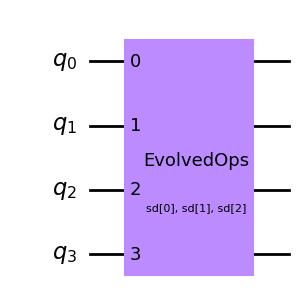

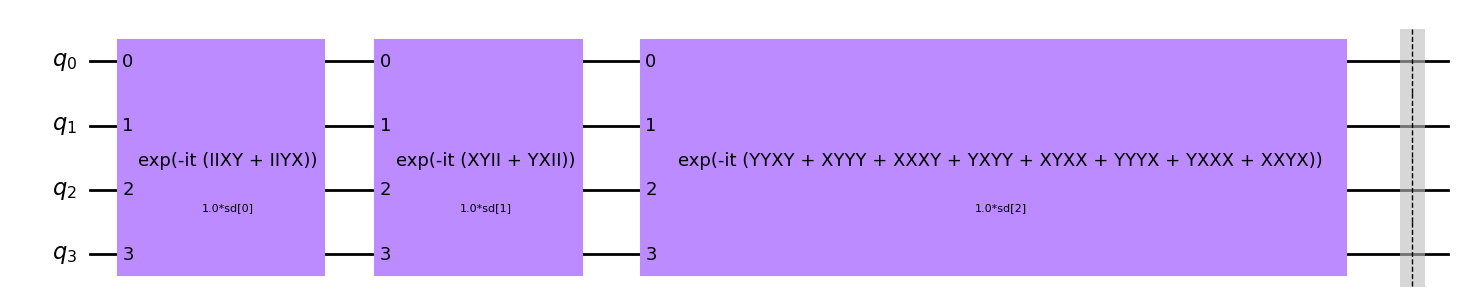

In [6]:
qc = QuantumCircuit(num_spin_orbitals)
qc.append(a.opertor_component,range(num_spin_orbitals))
display(qc.draw('mpl'))
display(qc.decompose(reps = 2).draw('mpl'))

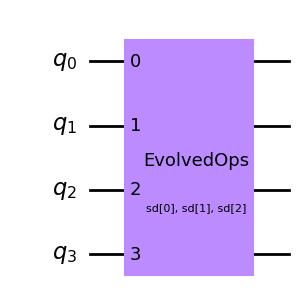

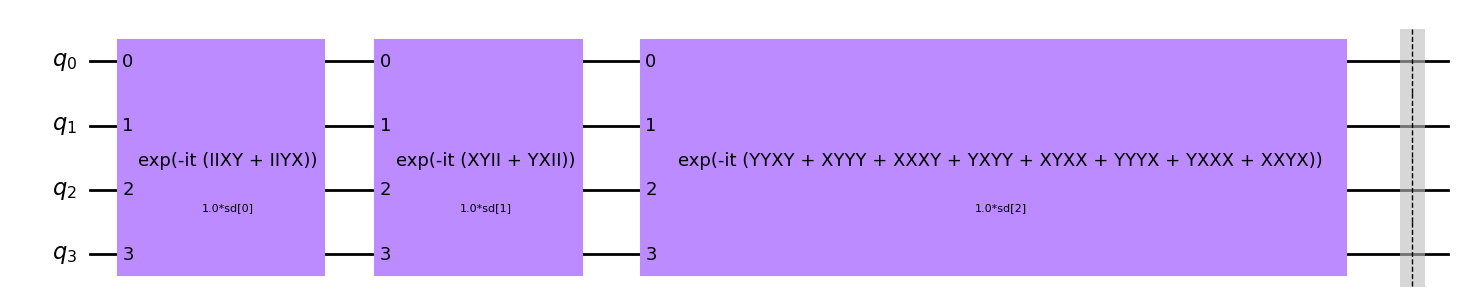

<bound method QuantumCircuit.decompose of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0f853d9360>>

In [7]:
qc = QuantumCircuit(problem.num_spin_orbitals)
qc.append(a.opertor_component,range(problem.num_spin_orbitals))
display(qc.draw('mpl'))
display(qc.decompose(reps=2).draw('mpl'))
part = qc.decompose(reps=2)
part.decompose

In [8]:
qc.num_parameters

3

In [9]:
for i in range(3):
    print(ansatz_list[i])

NameError: name 'ansatz_list' is not defined

In [ ]:
cc = QuantumCircuit(4)
cc.append(part[0],[0,1,2,3])
